In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as utils
import torch.optim.lr_scheduler as lr_scheduler
from torch.distributions import Distribution
from torch.distributions.dirichlet import Dirichlet
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


import os 
get_cwd = os.getcwd()
root_dir = os.path.dirname(get_cwd)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

import sys
sys.path.append(r'c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN')
sys.path.append(r'c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN\postnet')

from postnet.PosteriorNetwork_class import NormalisingFlow, AffineCouplingLayer, Conditioner, PosteriorNetwork
from postnet.LoadDataset_class import LoadDataset



training_lr = 3e-4 # start of training (end of warmup ) #Note: High LR create NaNs and Inf 
start_lr = 1e-9 # start of warmup
min_lr = 1e-7 # during cosine annealing
num_epochs = 50 # flere epochs maybe 12000
warmup_steps= 500
validation_every_steps = 50 # is actually every epoch in training loop!!
#validation_every_epochs = 1
weight_decay = 5e-7  # L2 regularization strength to prevent overfitting in Adam or AdamW 
batch_size = 64
early_stop_delta = 0.001 #in procent this is 0.1% 
early_stop_patience = 20 # so after 20 validations without improvement, stop training
split = lambda x: x.chunk(2, dim=-1)
reg = 1e-6 # entropy regularisation
annealing_interval = 40 # Every 10 epochs, anneal LR (warm restart)

num_classes = 10
latent_dim = 6 # Change to 4 or 6    # the encoder outputs 2D latent space
data_dim = 6 # the encoder outputs n-D latent space
in_dim= data_dim // 2 # since we split the data
out_dim= data_dim // 2
num_params = 2 # s and t
num_hidden = 3 # number of hidden layers
hidden_dim = 64 # neurons in hidden layers
num_flows = 6 # number of coupling flow layers

dataset_name = 'MNIST'
subset_percentage = 1
split_ratios = [.6, .8] 

"""
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
dataset = LoadDataset('MNIST', './data', train=True, transform=transform, subset_percentage=subset_percentage, split_ratios=split_ratios, seed=seed)
train_loader, val_loader, test_loader, N = dataset.get_data_loaders(batch_size=batch_size, split_ratios=split_ratios)
y_train = train_loader.dataset.dataset.targets
N_train = dataset.get_class_counts(dataset.train_indices)
N_test = dataset.get_class_counts(dataset.test_indices)

val_length = sum(len(batch) for batch, _ in val_loader)
train_set_length = sum(len(batch) for batch, _ in train_loader)
test_set_length = sum(len(batch) for batch, _ in test_loader)

# transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ]) # makes MNIST pixels [-1, 1]
# dataset = LoadDataset('MNIST', './data', train=True, transform=transform, subset_percentage=subset_percentage, split_ratios=split_ratios, seed=seed)
# train_loader, val_loader, test_loader = dataset.get_data_loaders(batch_size=batch_size, split_ratios=split_ratios)

# y_train = train_loader.dataset.dataset.targets
# N_train = dataset.get_class_counts(dataset.train_indices)
# N_val = dataset.get_class_counts(dataset.val_indices)
# N_test = dataset.get_class_counts(dataset.test_indices)

device = torch.device("cpu")
flow_models = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split, data_dim) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device)) #maybe move out of loop?
    flow_model = NormalisingFlow(latent_distribution, flows).to(device)
    #flow_model = NormalisingFlow(latent_distribution, flows).apply(init_weights).to(device)
    flow_models.append(flow_model)
testing_model = PosteriorNetwork(latent_dim, flow_models, N_train, num_classes, y_train, reg, dataset_name).to(device)
testing_model.load_state_dict(torch.load(f"{get_cwd}\\best_model_mnist_friday3.pth", map_location=device)['model_state_dict'])
print("Model loaded from", f"{get_cwd}\\best_model_mnist_friday3.pth")


def test(model, test_loader, device):
    # Load the best saved model
    checkpoint = torch.load('best_model_mnist_friday2.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    # Put the model in evaluation mode
    model.eval()
    # Initialize the number of correct predictions and the total number of predictions
    total_correct = 0
    total = 0
    # No gradient needed
    with torch.no_grad():
        for X_test, y_test in test_loader:
            # Move data to the same device as the model
            X_test, y_test = X_test.to(device), y_test.to(device)
            # Forward pass
            alpha = model(X_test, N_test)
            preds = torch.max(alpha, dim=-1)[1]
            # Count correct predictions
            total_correct += (preds == y_test).sum().item()
            total += y_test.size(0)
    # Calculate the accuracy
    test_accuracy = total_correct / total
    return test_accuracy
# Calculate test accuracy

test_accuracy = test(testing_model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')"""

'\ntransform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])\ndataset = LoadDataset(\'MNIST\', \'./data\', train=True, transform=transform, subset_percentage=subset_percentage, split_ratios=split_ratios, seed=seed)\ntrain_loader, val_loader, test_loader, N = dataset.get_data_loaders(batch_size=batch_size, split_ratios=split_ratios)\ny_train = train_loader.dataset.dataset.targets\nN_train = dataset.get_class_counts(dataset.train_indices)\nN_test = dataset.get_class_counts(dataset.test_indices)\n\nval_length = sum(len(batch) for batch, _ in val_loader)\ntrain_set_length = sum(len(batch) for batch, _ in train_loader)\ntest_set_length = sum(len(batch) for batch, _ in test_loader)\n\n# transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ]) # makes MNIST pixels [-1, 1]\n# dataset = LoadDataset(\'MNIST\', \'./data\', train=True, transform=transform, subset_percentage=subset_percentage, split_ratios=split_ratios, seed=

In [16]:
sys.path.append(r'c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN')
from postnet.metrics import accuracy, brier_score, confidence, ood_detection, entropy
split_ratios = [0.6, 0.8]

###### TESTING #####
subset_percentage = 1
ood_subset_percentage = 1
dataset_name = 'MNIST'
device = torch.device("cpu")
# transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ]) # makes MNIST pixels [-1, 1]
# dataset = LoadDataset(dataset_name, './data', train=False, transform=transform, subset_percentage=subset_percentage, split_ratios=split_ratios, seed=seed)
# test_loader = dataset.get_full_loader(batch_size=batch_size)


transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
dataset = LoadDataset('MNIST', './data', train=True, transform=transform, subset_percentage=subset_percentage, split_ratios=split_ratios, seed=seed)
train_loader, val_loader, test_loader, N = dataset.get_data_loaders(batch_size=batch_size, split_ratios=split_ratios)
y_train = train_loader.dataset.dataset.targets
N_train = dataset.get_class_counts(dataset.train_indices)
N_test = dataset.get_class_counts(dataset.test_indices)

val_length = sum(len(batch) for batch, _ in val_loader)
train_set_length = sum(len(batch) for batch, _ in train_loader)
test_set_length = sum(len(batch) for batch, _ in test_loader)


flow_models = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split, data_dim) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device)) #maybe move out of loop?

    flow_model = NormalisingFlow(latent_distribution, flows).to(device)
    #flow_model = NormalisingFlow(latent_distribution, flows).apply(init_weights).to(device)
    flow_models.append(flow_model)
testing_model = PosteriorNetwork(latent_dim, flow_models, N_train, num_classes, y_train, reg, dataset_name).to(device)
checkpoint = torch.load('best_model_mnist_friday2.pth')
device = torch.device("cpu")

ood_dataset_names = ['FashionMNIST', 'KMNIST']
ood_dataset_loaders = {}
ood_N = {}
#ood_N[ood_dataset_name]
for ood_dataset_name in ood_dataset_names: 
    ood_dataset = LoadDataset(ood_dataset_name, './data', train=False, transform=transform, subset_percentage=ood_subset_percentage, split_ratios=split_ratios, seed=seed)
    ood_dataset_loaders[ood_dataset_name] = ood_dataset.get_full_loader(batch_size=batch_size)
    ood_N[ood_dataset_name] = ood_dataset.get_class_counts(ood_dataset.indices)

print("N_test", N_test)
print("ood_N Fashion", ood_N['FashionMNIST'])
print("ood_N KMNIST", ood_N['KMNIST'])

#print("Observations in MNIST test_loader:", len(test_loader.dataset))
test_set_length = sum(len(batch) for batch, _ in test_loader)
print("Observations in MNIST test_loader:", test_set_length)
#print("length of test_indices", len(dataset.test_indices)) also gives 12000

print("Observations in FashionMNIST test_loader:", len(ood_dataset_loaders['FashionMNIST'].dataset))
print("Observations in KMNIST test_loader:", len(ood_dataset_loaders['KMNIST'].dataset))

def compute_all_y_alphas(model, loader, N, device):
    all_y_test = []
    all_alphas = []
    with torch.no_grad():
        for X_test, y_test in loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # Forward pass
            alpha = model(X_test, N)
            all_y_test.append(y_test.cpu())
            all_alphas.append(alpha.cpu())
    
    all_y_test = torch.cat(all_y_test)
    all_alphas = torch.cat(all_alphas)

    return all_y_test, all_alphas

def evaluate_model(model, test_loader, ood_dataset_loaders, N_test, ood_N, checkpoint, device):
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    #test_loader.dataset
    all_y_test, all_alphas = compute_all_y_alphas(model, test_loader, N_test, device)

    test_metrics = {}
    test_metrics['accuracy'] = accuracy(y=all_y_test, alpha=all_alphas)
    test_metrics['brier_score'] = brier_score(y=all_y_test, alpha=all_alphas)
    test_metrics['confidence_APR_aleatoric'] = confidence(y=all_y_test, alpha=all_alphas, score_type='APR', uncertainty_type='aleatoric')
    test_metrics['confidence_APR_epistemic'] = confidence(y=all_y_test, alpha=all_alphas, score_type='APR', uncertainty_type='epistemic')
    
    # Compute anomaly detection metrics for Fashion-MNIST and KMNIST in ood_dataset_loaders
    for ood_dataset_name, ood_dataset_loader in ood_dataset_loaders.items():
        _, ood_all_alphas = compute_all_y_alphas(model, ood_dataset_loader, ood_N[ood_dataset_name], device)
        test_metrics[f'ood_detection_aleatoric_{ood_dataset_name}'] = ood_detection(alpha=all_alphas, ood_alpha=ood_all_alphas, score_type='APR', uncertainty_type='aleatoric')
        test_metrics[f'ood_detection_epistemic_{ood_dataset_name}'] = ood_detection(alpha=all_alphas, ood_alpha=ood_all_alphas, score_type='APR', uncertainty_type='epistemic') 

    return test_metrics
    
test_metrics = evaluate_model(testing_model, test_loader, ood_dataset_loaders, N_test, ood_N, checkpoint, device)
for key, value in test_metrics.items():
    print(f'{key}: {value}')

N_test tensor([1172., 1387., 1216., 1165., 1139., 1066., 1207., 1258., 1204., 1186.],
       dtype=torch.float64)
ood_N Fashion tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       dtype=torch.float64)
ood_N KMNIST tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.],
       dtype=torch.float64)
Observations in MNIST test_loader: 12000
length of test_indices 12000
Observations in FashionMNIST test_loader: 10000
Observations in KMNIST test_loader: 10000
accuracy: 0.9705833333333334
brier_score: 0.10386969894170761
confidence_APR_aleatoric: 0.9947050466923587
confidence_APR_epistemic: 0.9866331015047678
ood_detection_aleatoric_FashionMNIST: 0.9297334328926299
ood_detection_epistemic_FashionMNIST: 0.903748011858729
ood_detection_aleatoric_KMNIST: 0.9165005877797091
ood_detection_epistemic_KMNIST: 0.8337101392908555


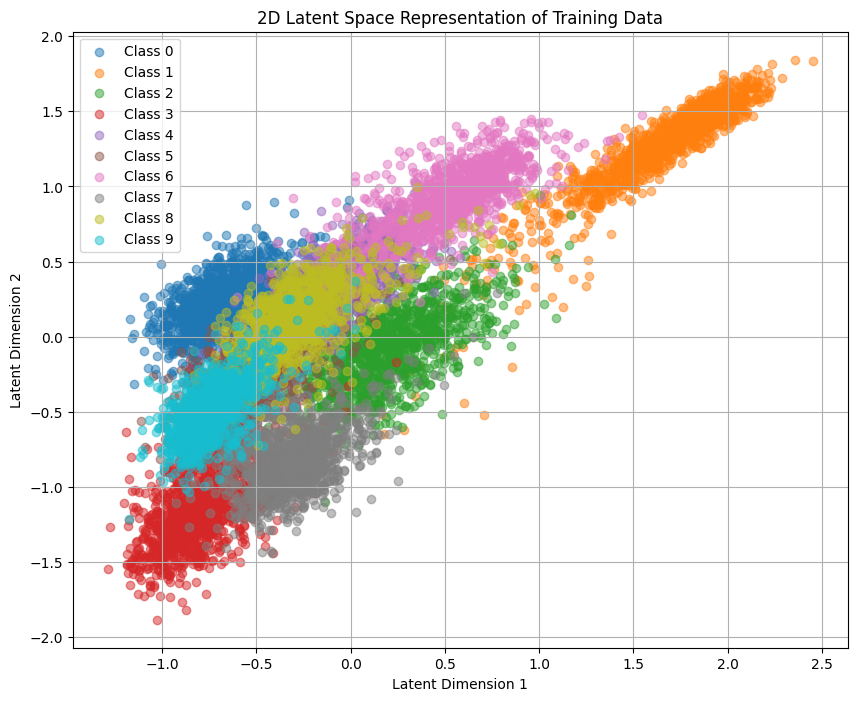

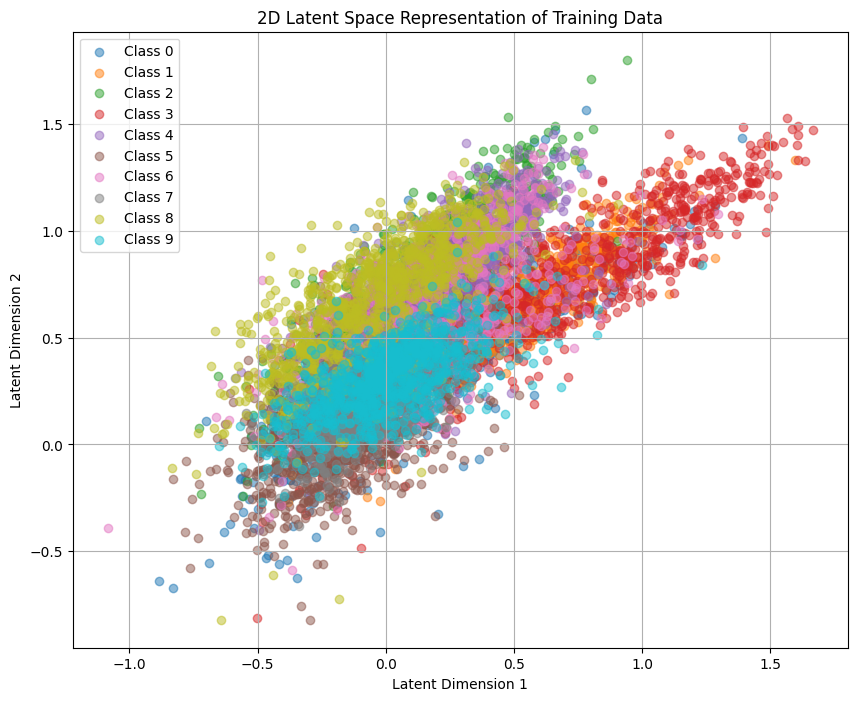

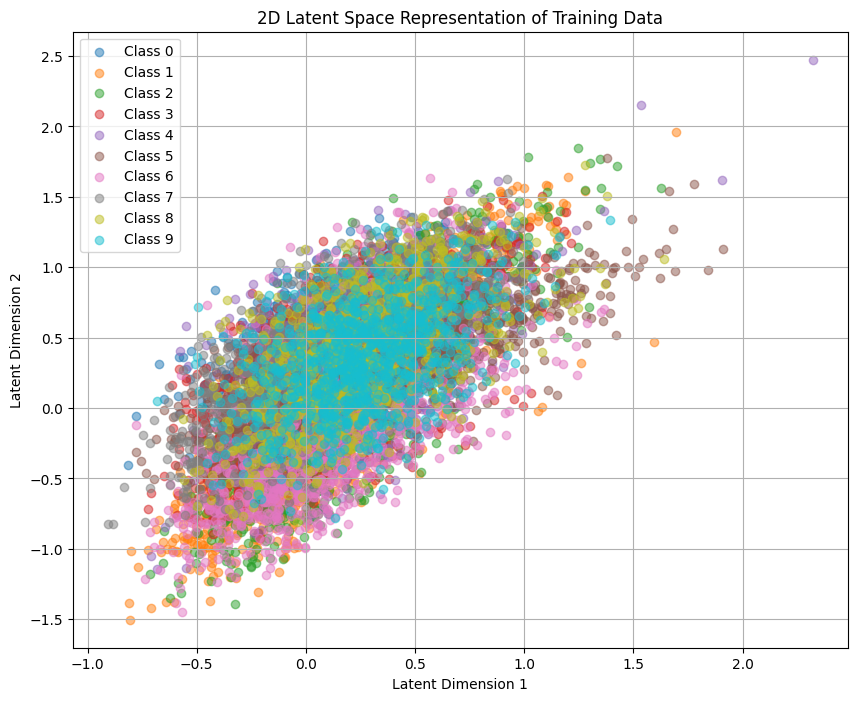

In [11]:
def extract_latent_representations(model, loader):
    model.eval()  # Set the model to evaluation mode
    latent_representations = []
    labels = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            latent_output = model.cnn(inputs)
            latent_representations.append(latent_output.cpu().numpy())
            labels.append(targets.cpu().numpy())

    return np.concatenate(latent_representations), np.concatenate(labels)

# Extract latent representations
def plot_latent_space(latent_data, labels):
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        indices = labels == i
        plt.scatter(latent_data[indices, 0], latent_data[indices, 1], label=f'Class {i}', alpha=0.5)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space Representation of Training Data')
    plt.legend()
    plt.grid(True)
    plt.show()

latent_test_data, test_labels = extract_latent_representations(testing_model, test_loader)
plot_latent_space(latent_test_data, test_labels)

latent_FashionMNIST_data, FashionMNIST_labels = extract_latent_representations(testing_model, ood_dataset_loaders['FashionMNIST'])
plot_latent_space(latent_FashionMNIST_data, FashionMNIST_labels)

latent_KMNIST_data, KMNIST_labels = extract_latent_representations(testing_model, ood_dataset_loaders['KMNIST'])
plot_latent_space(latent_KMNIST_data, KMNIST_labels)



In [8]:
sys.path.append(r'c:\Users\ollie\OneDrive - Danmarks Tekniske Universitet\Uni\Bachelor Projekt\Normalising-Flow-DNN')
from postnet.metrics import accuracy, brier_score, confidence, ood_detection, entropy
split_ratios = [0.6, 0.8]

###### TESTING #####
subset_percentage = 1
ood_subset_percentage = 1
dataset_name = 'MNIST'
device = torch.device("cpu")
checkpoint = torch.load('best_model_mnist_friday2.pth')

ood_dataset_names = ['FashionMNIST', 'KMNIST']
ood_dataset_loaders = {}
for ood_dataset_name in ood_dataset_names: 
    ood_dataset = LoadDataset(ood_dataset_name, './data', train=False, transform=transform, subset_percentage=ood_subset_percentage, split_ratios=split_ratios, seed=seed)
    ood_dataset_loaders[ood_dataset_name] = ood_dataset.get_full_loader(batch_size=batch_size)

print("Observations in MNIST test_loader:", len(test_loader.dataset))
print("Observations in FashionMNIST test_loader:", len(ood_dataset_loaders['FashionMNIST'].dataset))
print("Observations in KMNIST test_loader:", len(ood_dataset_loaders['KMNIST'].dataset))

def compute_all_y_alphas(model, loader, device):
    all_y_test = []
    all_alphas = []
    with torch.no_grad():
        for X_test, y_test in loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # Forward pass
            alpha = model(X_test, N)
            all_y_test.append(y_test.cpu())
            all_alphas.append(alpha.cpu())
    
    all_y_test = torch.cat(all_y_test)
    all_alphas = torch.cat(all_alphas)

    return all_y_test, all_alphas

def evaluate_model(model, test_loader, ood_dataset_loaders, checkpoint, device):
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    all_y_test, all_alphas = compute_all_y_alphas(model, test_loader, device)

    test_metrics = {}
    test_metrics['accuracy'] = accuracy(y=all_y_test, alpha=all_alphas)
    test_metrics['brier_score'] = brier_score(y=all_y_test, alpha=all_alphas)
    test_metrics['confidence_APR_aleatoric'] = confidence(y=all_y_test, alpha=all_alphas, score_type='APR', uncertainty_type='aleatoric')
    test_metrics['confidence_APR_epistemic'] = confidence(y=all_y_test, alpha=all_alphas, score_type='APR', uncertainty_type='epistemic')
    
    # Compute anomaly detection metrics for Fashion-MNIST and KMNIST in ood_dataset_loaders
    for ood_dataset_name, ood_dataset_loader in ood_dataset_loaders.items():
        _, ood_all_alphas = compute_all_y_alphas(model, ood_dataset_loader, device)
        test_metrics[f'ood_detection_aleatoric_{ood_dataset_name}'] = ood_detection(alpha=all_alphas, ood_alpha=ood_all_alphas, score_type='APR', uncertainty_type='aleatoric')
        test_metrics[f'ood_detection_epistemic_{ood_dataset_name}'] = ood_detection(alpha=all_alphas, ood_alpha=ood_all_alphas, score_type='APR', uncertainty_type='epistemic') 

    return test_metrics
    
test_metrics = evaluate_model(testing_model, test_loader, ood_dataset_loaders, checkpoint, device)
for key, value in test_metrics.items():
    print(f'{key}: {value}')

Observations in MNIST test_loader: 60000
Observations in FashionMNIST test_loader: 10000
Observations in KMNIST test_loader: 10000
accuracy: 0.9705833333333334
brier_score: 0.07911103218793869
confidence_APR_aleatoric: 0.9962695232411475
confidence_APR_epistemic: 0.9865519669755356
ood_detection_aleatoric_FashionMNIST: 0.9349780781377912
ood_detection_epistemic_FashionMNIST: 0.8849100007897577
ood_detection_aleatoric_KMNIST: 0.9128953482274668
ood_detection_epistemic_KMNIST: 0.8098450056560307


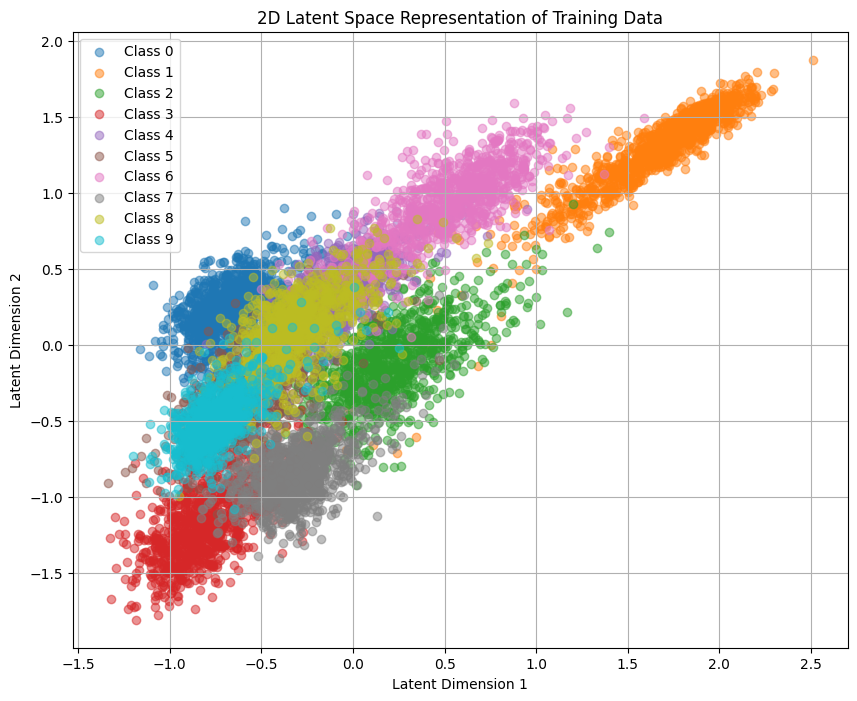

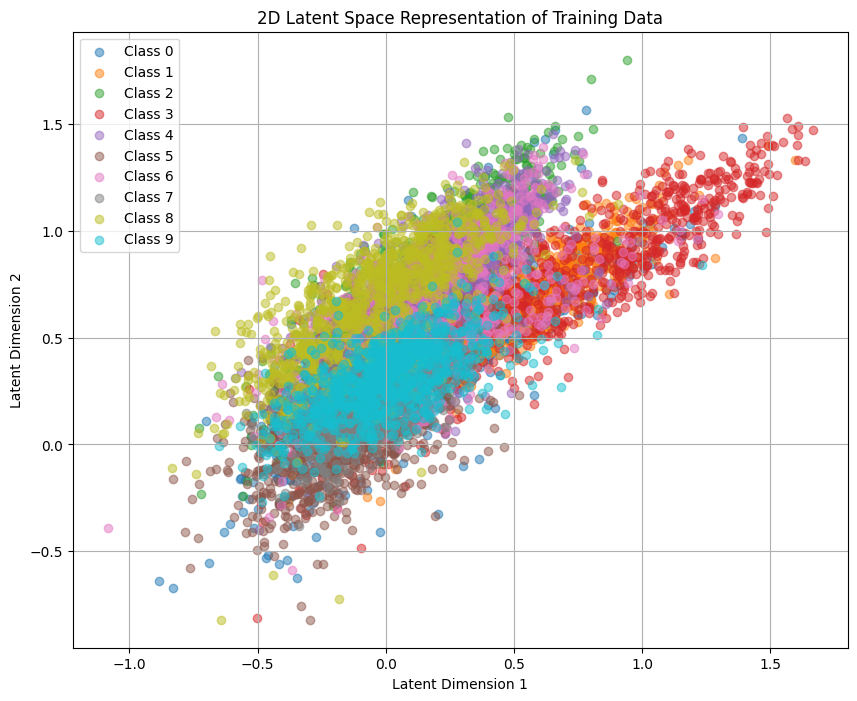

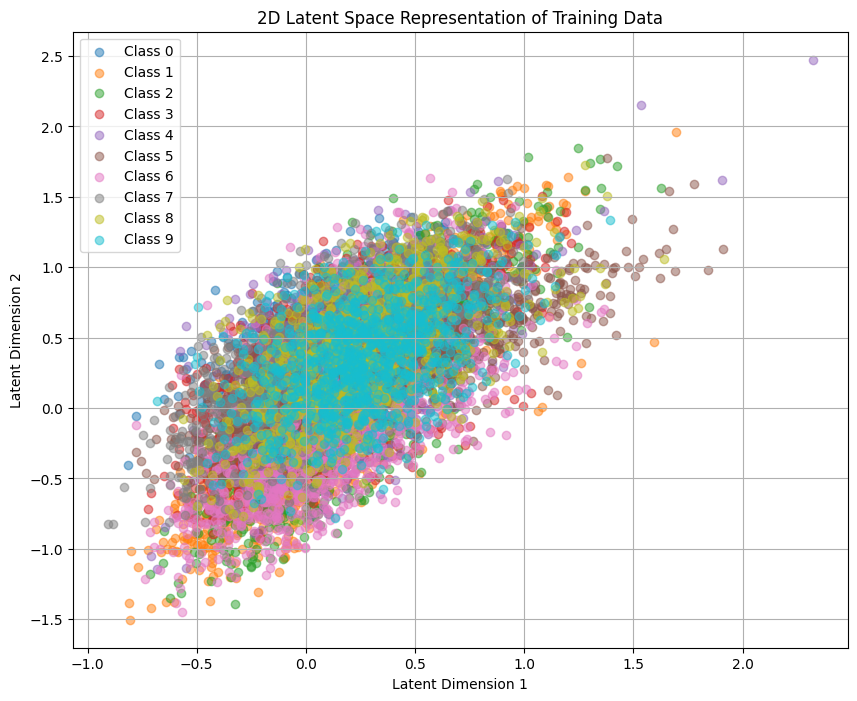

In [13]:
transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ]) # makes MNIST pixels [-1, 1]
dataset = LoadDataset(dataset_name, './data', train=False, transform=transform, subset_percentage=subset_percentage, split_ratios=split_ratios, seed=seed)
mnist_loader = dataset.get_full_loader(batch_size=batch_size)

latent_test_data, test_labels = extract_latent_representations(testing_model, mnist_loader)
plot_latent_space(latent_test_data, test_labels)
latent_test_data, test_labels = extract_latent_representations(testing_model, ood_dataset_loaders['FashionMNIST'])
plot_latent_space(latent_test_data, test_labels)
latent_test_data, test_labels = extract_latent_representations(testing_model, ood_dataset_loaders['KMNIST'])
plot_latent_space(latent_test_data, test_labels)